In [1]:
import math

from common import *
from experiment import *
from data import RawData, PlottableData

In [2]:
TREATMENTS = [
    TCPTreatment(cca='cubic', pep=False),
    TCPTreatment(cca='cubic', pep=True),
    TCPTreatment(cca='bbr', pep=False),
    TCPTreatment(cca='bbr', pep=True),
]
TCP_CUBIC = TREATMENTS[0]
PEP_CUBIC = TREATMENTS[1]
TCP_BBRV3 = TREATMENTS[2]
PEP_BBRV3 = TREATMENTS[3]

In [3]:
MIRROR = True
NETWORKS = [
    NetworkSetting(bw1=300, bw2=100, delay1=1, delay2=25),
    NetworkSetting(bw1=300, bw2=100, delay1=1, delay2=50),
    NetworkSetting(bw1=100, bw2=10, delay1=1, delay2=25),
    NetworkSetting(bw1=100, bw2=10, delay1=1, delay2=50),
]
NETWORKS = [n.mirror() if MIRROR else n for n in NETWORKS]
DEFAULT_NETWORK = NETWORKS[2]
NET_HIGH_BW = NETWORKS[0]
NET_HIGH_BW_DELAY = NETWORKS[1]
NET_HIGH_DELAY = NETWORKS[3]

# Investigate Throughput

## Data size vs. thoughput line graph, with error bars

### Plotting function

In [4]:
def plot_data_size_vs_metric_line(data, delta, title, ylabel):
    plt.figure(figsize=(6, 4))
    
    labels = data.treatments
    assert len(data.network_settings) == 1
    network = data.network_settings[0]

    for label in labels:
        subdata = data.data[label][network]
        xs_raw = sorted(subdata.keys())
        ys_raw = [subdata[x] for x in xs_raw]

        xs = [x/1000 for x in xs_raw]
        ys = [y.p(50) for y in ys_raw]
        yerr_lower = [y.p(50) - y.p(50-delta) for y in ys_raw]
        yerr_upper = [y.p(50+delta) - y.p(50) for y in ys_raw]
        plt.errorbar(xs, ys, yerr=(yerr_lower, yerr_upper), marker='.', capsize=5, label=label)

    plt.title(title)
    plt.xlabel('Download Data Size (KB)')
    plt.ylabel(ylabel)
    plt.grid()
    plt.xlim(0)
    plt.ylim(0)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4)
    plt.show()

### Original bandwidth (100 Mbit/s and 10 Mbit/s)

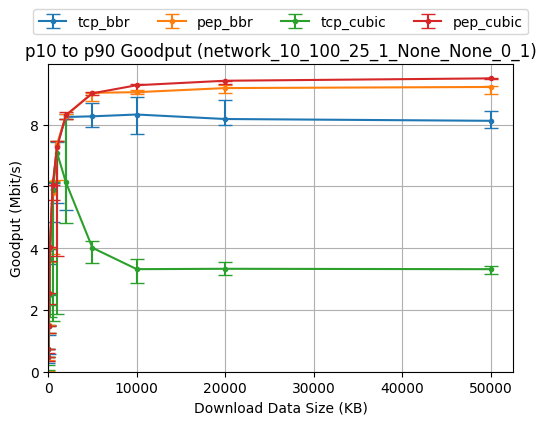

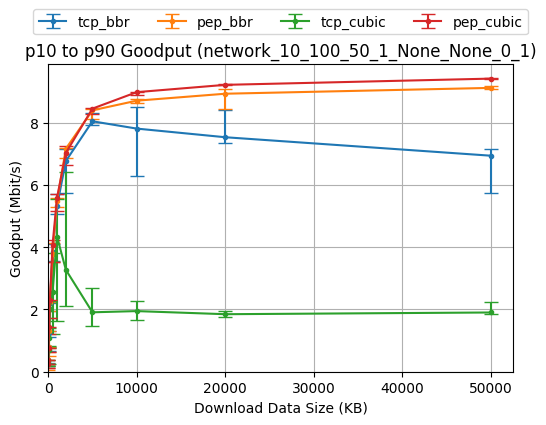

In [5]:
# Experiment settings
execute = True
num_trials = 5
treatments = [TCP_BBRV3, PEP_BBRV3, TCP_CUBIC, PEP_CUBIC]
network_settings = [DEFAULT_NETWORK, NET_HIGH_DELAY]
data_sizes = [
    10000, 20000, 50000, # 10-99KB
    100000, 200000, 500000, # 100-999KB
    1000000, 2000000, 5000000, # 1-9MB
    10000000, 20000000, 50000000, # 10-99MB
    # 100000000, 200000000, 500000000, # 100-999MB
]

# Plotting settings
for network_setting in network_settings:
    exp = Experiment(num_trials, treatments, [network_setting], data_sizes)
    raw_data = RawData(exp, execute=execute)
    
    delta = 40
    title = f'p{50-delta} to p{50+delta} Goodput ({network_setting.label()})'
    metric = 'throughput_mbps'
    ylabel = 'Goodput (Mbit/s)'
    plottable_data = PlottableData(raw_data, metric=metric)
    plot_data_size_vs_metric_line(plottable_data, delta=delta, title=title, ylabel=ylabel)

### Higher bandwidths (300 Mbit/s and 100 Mbit/s)

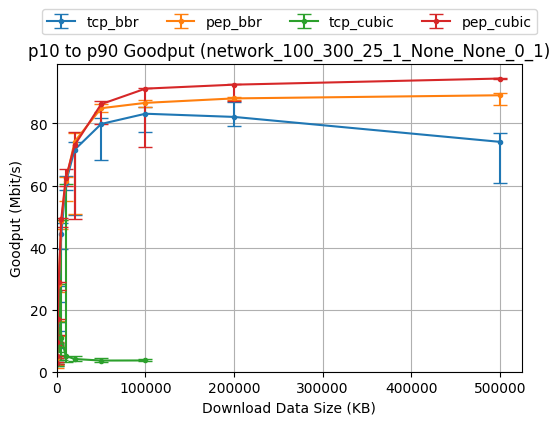

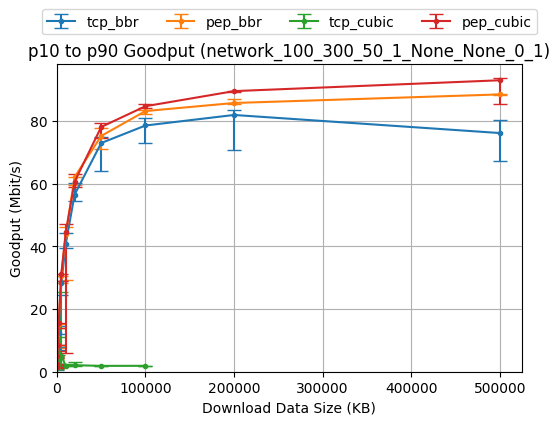

In [6]:
## Experiment settings
execute = True
num_trials = 5
treatments = [TCP_BBRV3, PEP_BBRV3, TCP_CUBIC, PEP_CUBIC]
network_settings = [NET_HIGH_BW, NET_HIGH_BW_DELAY]
data_sizes = [
    # 10000, 20000, 50000, # 10-99KB
    100000, 200000, 500000, # 100-999KB
    1000000, 2000000, 5000000, # 1-9MB
    10000000, 20000000, 50000000, # 10-99MB
    100000000, 200000000, 500000000, # 100-999MB
]

# Plotting settings
for network_setting in network_settings:
    exp = Experiment(num_trials, treatments, [network_setting], data_sizes)
    raw_data = RawData(exp, max_data_sizes={TCP_CUBIC.label(): 10}, execute=execute)
    
    delta = 40
    title = f'p{50-delta} to p{50+delta} Goodput ({network_setting.label()})'
    metric = 'throughput_mbps'
    ylabel = 'Goodput (Mbit/s)'
    plottable_data = PlottableData(raw_data, metric=metric)
    plot_data_size_vs_metric_line(plottable_data, delta=delta, title=title, ylabel=ylabel)

## Loss near data receiver vs. throughput line graph, with error bars

### Plotting function

In [19]:
loss_key = 'loss2' if MIRROR else 'loss1'
xlabel = 'Loss % near data sender' if MIRROR else 'Loss % near data receiver'

In [23]:
def plot_loss_vs_metric_line(data, delta, title, ylabel, xlabel=xlabel):
    plt.figure(figsize=(6, 4))
    
    labels = data.treatments
    assert len(data.data_sizes) == 1
    data_size = data.data_sizes[0]

    # Plot each label
    for label in labels:
        xs = []
        ys_raw = []

        for network in data.network_settings:
            if data_size not in data.data[label][network]:
                continue
            network_setting = data.exp.get_network_setting(network)
            xs.append(float(network_setting.settings[loss_key]))
            ys_raw.append(data.data[label][network][data_size])

        ys = [y.p(50) for y in ys_raw]
        yerr_lower = [y.p(50) - y.p(50-delta) for y in ys_raw]
        yerr_upper = [y.p(50+delta) - y.p(50) for y in ys_raw]
        plt.errorbar(xs, ys, yerr=(yerr_lower, yerr_upper), marker='.', capsize=5, label=label)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.xlim(0)
    plt.ylim(0)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4)
    plt.show()

### Original bandwidths (100 Mbit/s and 10 Mbit/s)

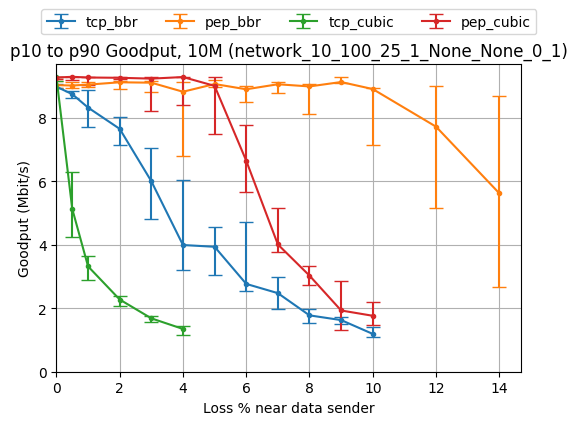

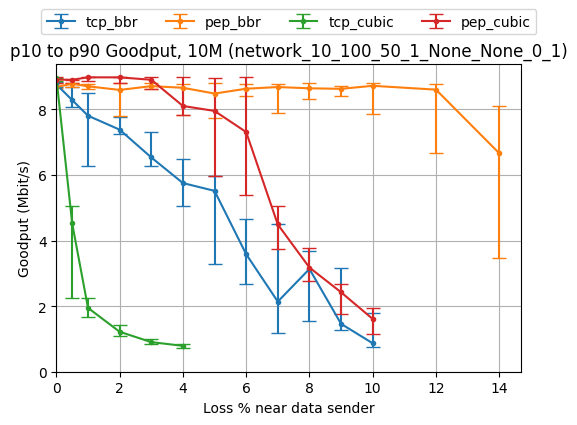

In [24]:
# Experiment settings
execute = True
num_trials = 5
treatments = [
    TCP_BBRV3,
    PEP_BBRV3,
    TCP_CUBIC,
    PEP_CUBIC,
]
data_size = 10000000 # 10MB

network_settings = []
original_network_settings = [DEFAULT_NETWORK, NET_HIGH_DELAY]
losses = [
    '0', '0.5', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '12', '14'
]
for original_network in original_network_settings:
    networks = []
    for loss in losses:
        network = original_network.clone()
        network.set(loss_key, loss)
        networks.append(network)
    network_settings.append(networks)

max_networks = {
    TCP_BBRV3.label(): 12, #12,
    PEP_BBRV3.label(): 14, #14,
    TCP_CUBIC.label(): 6, #6,
    PEP_CUBIC.label(): 12, #12,
}

# Plotting settings
for original_network_setting, network_setting in zip(original_network_settings, network_settings):    
    exp = Experiment(num_trials, treatments, network_setting, [data_size])
    raw_data = RawData(exp, execute=execute, max_networks=max_networks)
    
    delta = 40
    title = f'p{50-delta} to p{50+delta} Goodput, {data_size_str(data_size)} ({original_network_setting.label()})'
    metric = 'throughput_mbps'
    ylabel = 'Goodput (Mbit/s)'
    plottable_data = PlottableData(raw_data, metric=metric)
    plot_loss_vs_metric_line(plottable_data, delta=delta, title=title, ylabel=ylabel)

### Higher bandwidths (300 Mbit/s and 100 Mbit/s)

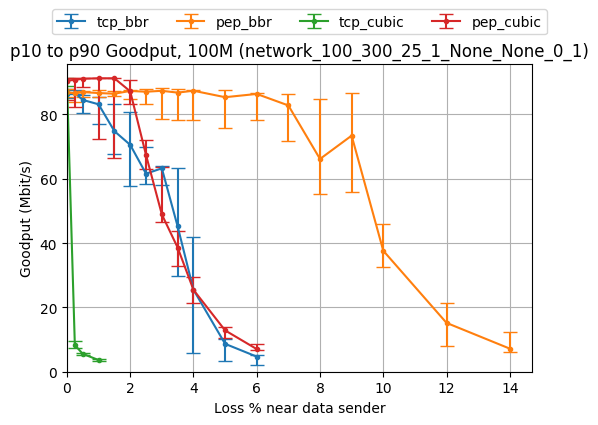

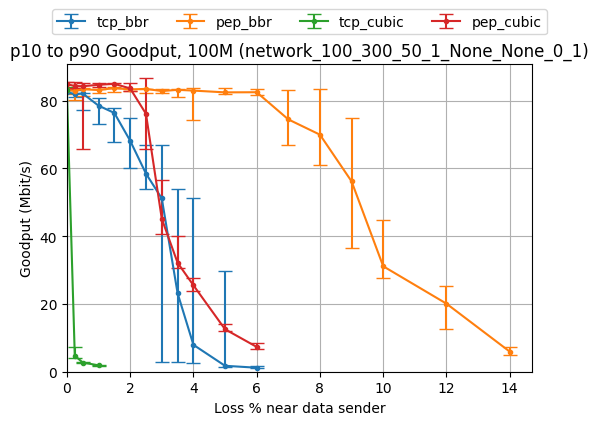

In [25]:
# Experiment settings
execute = True
num_trials = 5
# treatments = [TCP_BBRV3, PEP_BBRV3, PEP_CUBIC]
treatments = [TCP_BBRV3, PEP_BBRV3, TCP_CUBIC, PEP_CUBIC]
data_size = 100000000 # 100MB

network_settings = []
original_network_settings = [NET_HIGH_BW, NET_HIGH_BW_DELAY]
losses = [
    '0', '0.25', '0.5', '1', '1.5', '2', '2.5', '3', '3.5', '4', '5', '6', '7', '8', '9', '10', '12', '14'
]
for original_network in original_network_settings:
    networks = []
    for loss in losses:
        network = original_network.clone()
        network.set(loss_key, loss)
        networks.append(network)
    network_settings.append(networks)

max_networks = {
    TCP_BBRV3.label(): 12, #12,
    PEP_BBRV3.label(): 18, #18,
    TCP_CUBIC.label(): 4, #4,
    PEP_CUBIC.label(): 12, #12,
}

# Plotting settings
for original_network_setting, network_setting in zip(original_network_settings, network_settings):
    exp = Experiment(num_trials, treatments, network_setting, [data_size])
    raw_data = RawData(exp, execute=execute, max_networks=max_networks)
    
    delta = 40
    title = f'p{50-delta} to p{50+delta} Goodput, {data_size_str(data_size)} ({original_network_setting.label()})'
    metric = 'throughput_mbps'
    ylabel = 'Goodput (Mbit/s)'
    plottable_data = PlottableData(raw_data, metric=metric)
    plot_loss_vs_metric_line(plottable_data, delta=delta, title=title, ylabel=ylabel)

# Investigate Latency Variance

## Data size vs. throughput for fixed data sizes bar graph, with error bars

### Plotting function

In [11]:
def hypotenuse(a, b):
    return math.sqrt(a*a+b*b)

def plot_data_size_vs_metric_bar(data, delta, title, ylabel, diff=False, prop=False):
    assert not (diff and prop)
    plt.figure(figsize=(6, 4))
    
    labels = data.treatments
    assert len(data.network_settings) == 1
    network = data.network_settings[0]

    # Prepare data
    xs_raw = sorted(data.data[labels[0]][network].keys())  # Assumes all labels share the same x-axis keys
    xs = [x/1000 for x in xs_raw]  # Convert to KB
    width = 0.6 / len(labels)  # Width of each bar
    x_positions = np.arange(len(xs))  # X positions for groups of bars

    # Get the baseline data
    if diff or prop:
        baseline = data.data[labels[0]][network]
        baseline_ys_raw = [baseline[x] for x in xs_raw]
        baseline_ys = [y.p(50) for y in baseline_ys_raw]
        baseline_yerr_lower = [y.p(50) - y.p(50-delta) for y in baseline_ys_raw]
        baseline_yerr_upper = [y.p(50+delta) - y.p(50) for y in baseline_ys_raw]
    
    # Plot bars for each label
    for i, label in enumerate(labels):
        subdata = data.data[label][network]
        ys_raw = [subdata[x] for x in xs_raw]

        ys = [y.p(50) for y in ys_raw]
        yerr_lower = [y.p(50) - y.p(50-delta) for y in ys_raw]
        yerr_upper = [y.p(50+delta) - y.p(50) for y in ys_raw]
        yerr = (yerr_lower, yerr_upper)

        # Plot the raw data, absolute difference from baseline,
        # or proportional difference from baseline
        if diff:
            ys = [ys[i] - baseline_ys[i] for i in range(len(ys))]
            yerr_lower = [hypotenuse(yerr_lower[i], baseline_yerr_lower[i]) for i in range(len(yerr_lower))]
            yerr_upper = [hypotenuse(yerr_upper[i], baseline_yerr_upper[i]) for i in range(len(yerr_upper))]
            yerr = (yerr_lower, yerr_upper)
        if prop:
            ys_ = [(ys[i] - baseline_ys[i]) / baseline_ys[i] for i in range(len(ys))]
            yerr_lower_ = []
            yerr_upper_ = []
            for j in range(len(ys)):
                if ys[j] == 0 or baseline_ys[j] == 0:
                    yerr_lower_.append(0)
                    yerr_upper_.append(0)
                else:
                    yerr_lower_.append(hypotenuse(yerr_lower[j] / ys[j], baseline_yerr_lower[j] / baseline_ys[j]))
                    yerr_upper_.append(hypotenuse(yerr_upper[j] / ys[j], baseline_yerr_upper[j] / baseline_ys[j]))
            ys = ys_
            yerr = (yerr_lower_, yerr_upper_)
        if i == 0 and (diff or prop):
            yerr = None

        positions = x_positions + i * width
        plt.bar(
            positions, ys, width=width, yerr=yerr,
            capsize=5, label=label, alpha=0.8
        )

    # Customize plot
    plt.xticks(x_positions + width * (len(labels) - 1) / 2, [f'{x:.1f}' for x in xs])  # Center tick labels
    plt.title(title)
    plt.xlabel('Download Data Size (KB)')
    plt.ylabel(ylabel)
    plt.grid(axis='y')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=len(labels))
    plt.tight_layout()
    plt.show()

### Higher bandwidths only (300 Mbit/s and 100 Mbit/s) and high delay, different data size ranges

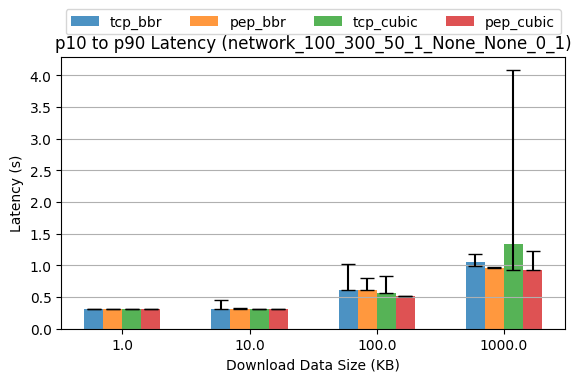

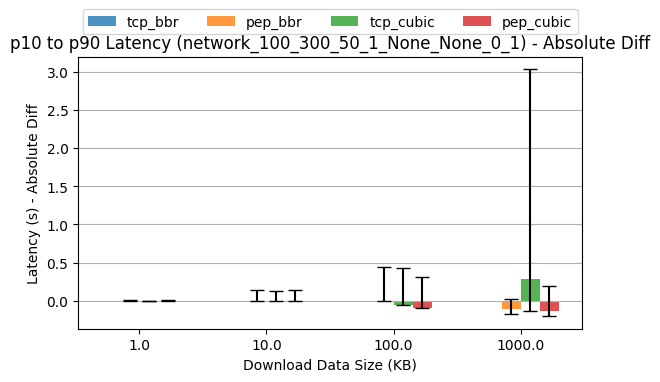

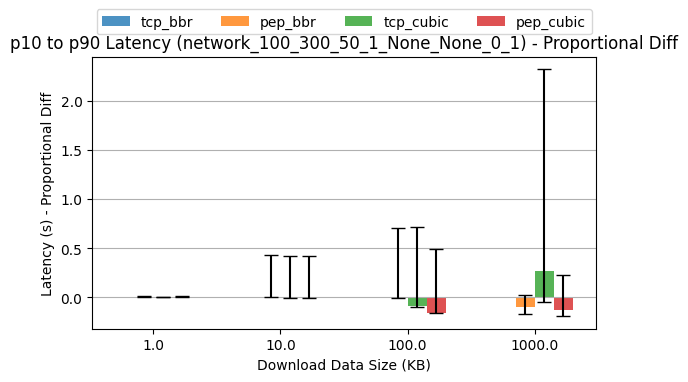

In [12]:
# Experiment settings
execute = True
num_trials = 50
treatments = [TCP_BBRV3, PEP_BBRV3, TCP_CUBIC, PEP_CUBIC]
network_setting = NET_HIGH_BW_DELAY
data_sizes = [
    1000, # 1KB
    10000,  # 10KB
    100000,  # 100KB
    1000000,  # 1MB
]
exp = Experiment(num_trials, treatments, [network_setting], data_sizes)
raw_data = RawData(exp, execute=execute)

# Plotting settings
delta = 40
title = f'p{50-delta} to p{50+delta} Latency ({network_setting.label()})'
metric = 'time_s'
ylabel = 'Latency (s)'
plottable_data = PlottableData(raw_data, metric=metric)
plot_data_size_vs_metric_bar(plottable_data, delta=delta, title=title, ylabel=ylabel)
plot_data_size_vs_metric_bar(plottable_data, delta=delta, title=f'{title} - Absolute Diff', ylabel=f'{ylabel} - Absolute Diff', diff=True)
plot_data_size_vs_metric_bar(plottable_data, delta=delta, title=f'{title} - Proportional Diff', ylabel=f'{ylabel} - Proportional Diff', prop=True)

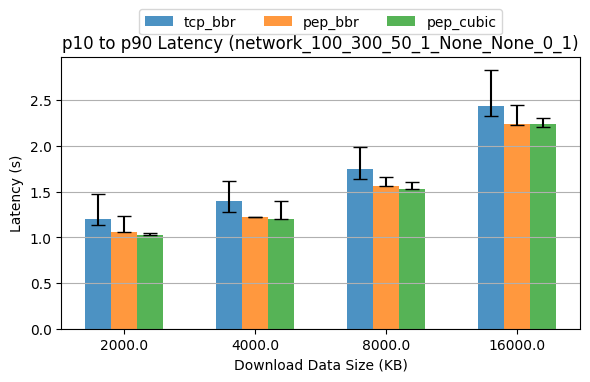

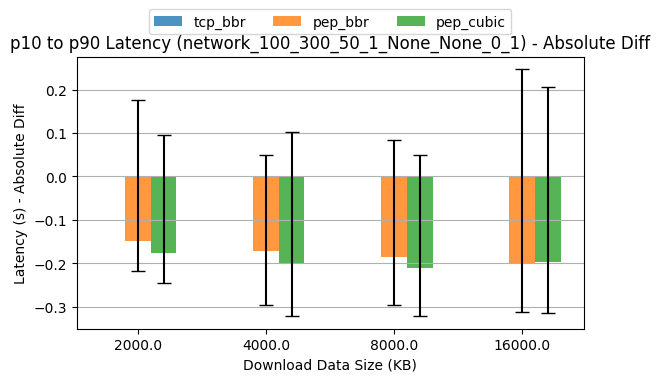

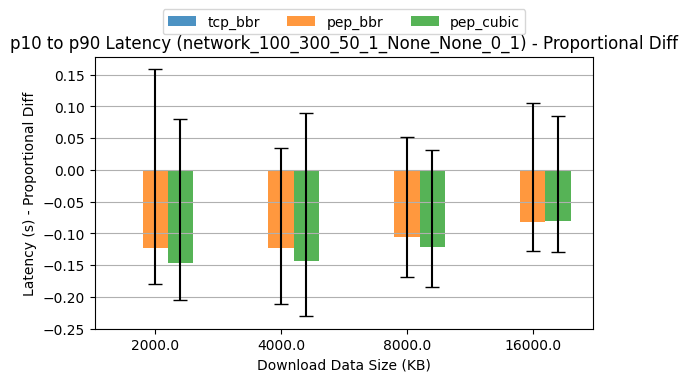

In [13]:
# Experiment settings
execute = True
num_trials = 50
treatments = [TCP_BBRV3, PEP_BBRV3, PEP_CUBIC]
# treatments = [TCP_BBRV3, PEP_BBRV3, TCP_CUBIC, PEP_CUBIC]
network_setting = NET_HIGH_BW_DELAY
data_sizes = [
    2000000, # 2MB
    4000000, # 4MB
    8000000, # 8MB
    16000000, # 16MB
]
exp = Experiment(num_trials, treatments, [network_setting], data_sizes)
raw_data = RawData(exp, execute=execute)

# Plotting settings
delta = 40
title = f'p{50-delta} to p{50+delta} Latency ({network_setting.label()})'
metric = 'time_s'
ylabel = 'Latency (s)'
plottable_data = PlottableData(raw_data, metric=metric)
plot_data_size_vs_metric_bar(plottable_data, delta=delta, title=title, ylabel=ylabel)
plot_data_size_vs_metric_bar(plottable_data, delta=delta, title=f'{title} - Absolute Diff', ylabel=f'{ylabel} - Absolute Diff', diff=True)
plot_data_size_vs_metric_bar(plottable_data, delta=delta, title=f'{title} - Proportional Diff', ylabel=f'{ylabel} - Proportional Diff', prop=True)

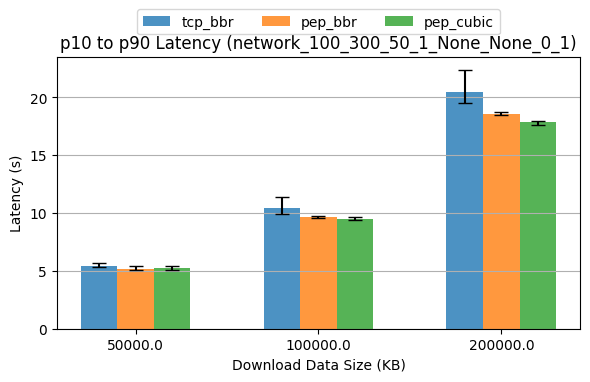

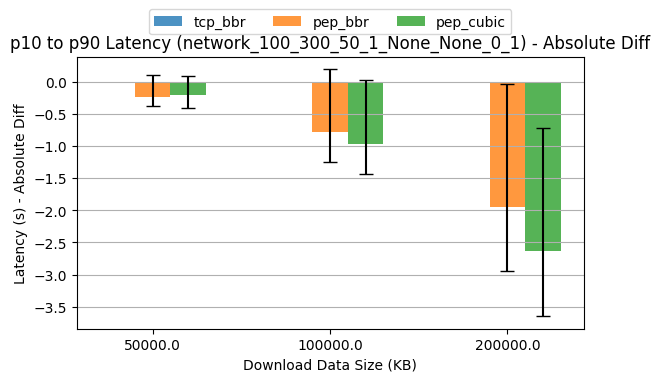

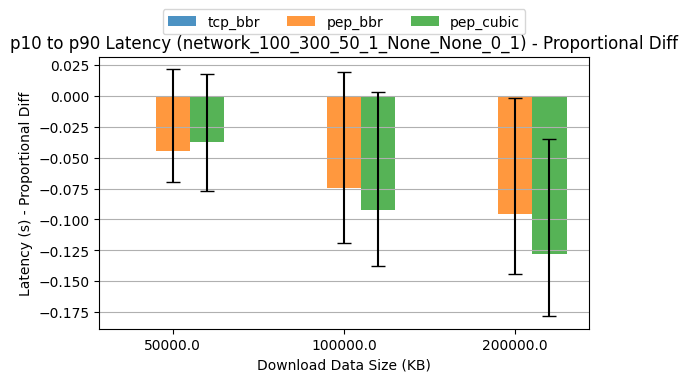

In [14]:
# Experiment settings
execute = True
num_trials = 50
treatments = [TCP_BBRV3, PEP_BBRV3, PEP_CUBIC]
# treatments = [TCP_BBRV3, PEP_BBRV3, TCP_CUBIC, PEP_CUBIC]
network_setting = NET_HIGH_BW_DELAY
data_sizes = [
    50000000, # 50MB
    100000000, # 100MB
    200000000, # 200MB
]
exp = Experiment(num_trials, treatments, [network_setting], data_sizes)
raw_data = RawData(exp, execute=execute)

# Plotting settings
delta = 40
title = f'p{50-delta} to p{50+delta} Latency ({network_setting.label()})'
metric = 'time_s'
ylabel = 'Latency (s)'
plottable_data = PlottableData(raw_data, metric=metric)
plot_data_size_vs_metric_bar(plottable_data, delta=delta, title=title, ylabel=ylabel)
plot_data_size_vs_metric_bar(plottable_data, delta=delta, title=f'{title} - Absolute Diff', ylabel=f'{ylabel} - Absolute Diff', diff=True)
plot_data_size_vs_metric_bar(plottable_data, delta=delta, title=f'{title} - Proportional Diff', ylabel=f'{ylabel} - Proportional Diff', prop=True)

## Latency CDF for fixed data size

### Plotting function

In [15]:
def plot_metric_cdf(data, title, xlabel):
    plt.figure(figsize=(6, 4))
    
    labels = data.treatments
    assert len(data.network_settings) == 1
    network = data.network_settings[0]
    assert len(data.data_sizes) == 1
    data_size = data.data_sizes[0]

    for label in labels:
        subdata = data.data[label][network][data_size]
        xs = subdata.sorted_data
        cdf = [i / len(xs) for i in range(1, len(xs) + 1)]
        plt.plot(xs, cdf, label=label)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('CDF')
    plt.grid()
    plt.xlim(0)
    plt.ylim(0, 1.05)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=len(labels))
    plt.tight_layout()
    plt.show()

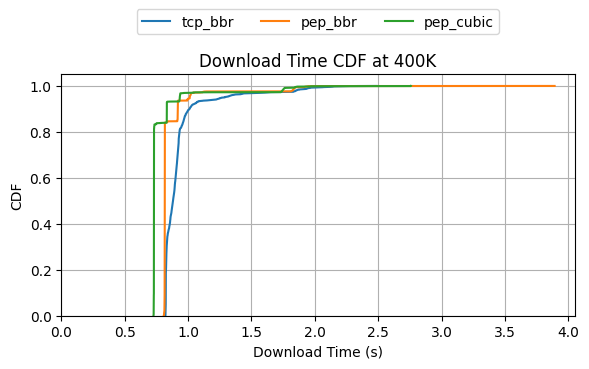

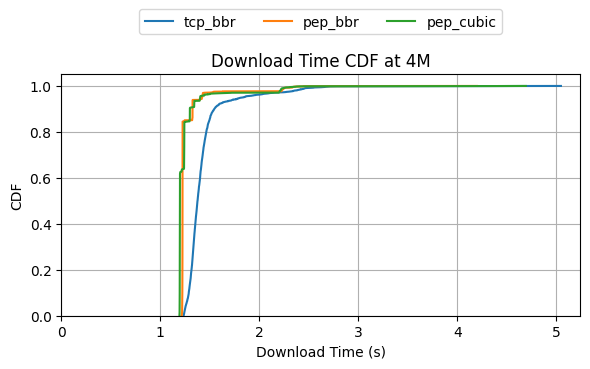

MISSING: sudo -E python3 emulation/main.py --bw2 300 --delay1 50 --delay2 1 --loss1 0 --loss2 1 -t 830 --label pep_cubic tcp --pep -cca cubic -n 16000000


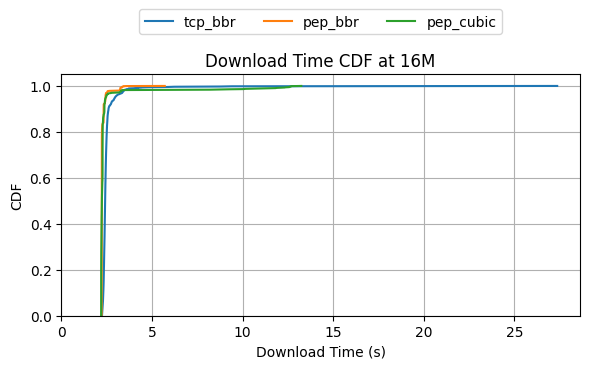

In [18]:
# Experiment settings
execute = True
num_trials = 2000
treatments = [TCP_BBRV3, PEP_BBRV3, PEP_CUBIC]
network_settings = [NET_HIGH_BW_DELAY]
data_sizes = [
    400000, # 400KB
    4000000, # 4MB
    16000000, # 16MB
]

for data_size in data_sizes:
    exp = Experiment(num_trials, treatments, network_settings, [data_size])
    raw_data = RawData(exp, execute=execute)
    
    # Plotting settings
    title = f'Download Time CDF at {data_size_str(data_size)}'
    metric = 'time_s'
    xlabel = 'Download Time (s)'
    plottable_data = PlottableData(raw_data, metric=metric)
    plot_metric_cdf(plottable_data, title=title, xlabel=xlabel)